参考：<a href="https://qiita.com/inoory/items/e63ade6f21766c7c2393">[Python] Keras-RLで簡単に強化学習(DQN)を試す</a>

In [1]:
import gym
import gym.spaces
import numpy as np

# 直線上を動く点の速度を操作し、目標(原点)に移動させることを目標とする環境
class PointOnLine(gym.core.Env):
    def __init__(self):
        self.action_space = gym.spaces.Discrete(3) # 行動空間。速度を下げる、そのまま、上げるの3種

        high = np.array([1.0, 1.0]) # 観測空間(state)の次元 (位置と速度の2次元) とそれらの最大値
        self.observation_space = gym.spaces.Box(low=-high, high=high) # 最小値は、最大値のマイナスがけ

    # 各stepごとに呼ばれる
    # actionを受け取り、次のstateとreward、episodeが終了したかどうかを返すように実装
    def _step(self, action):
        # actionを受け取り、次のstateを決定
        dt = 0.1
        acc = (action - 1) * 0.1
        self._vel += acc * dt
        self._vel = max(-1.0,  min(self._vel, 1.0))
        self._pos += self._vel * dt
        self._pos = max(-1.0,  min(self._pos, 1.0))

        # 位置と速度の絶対値が十分小さくなったらepisode終了
        done = abs(self._pos) < 0.1 and abs(self._vel) < 0.1

        if done:
            # 終了したときに正の報酬
            reward = 1.0
        else:
            # 時間経過ごとに負の報酬
            # ゴールに近づくように、距離が近くなるほど絶対値を減らしておくと、学習が早く進む
            reward = -0.01 * abs(self._pos)

        # 次のstate、reward、終了したかどうか、追加情報の順に返す
        # 追加情報は特にないので空dict
        return np.array([self._pos, self._vel]), reward, done, {}

    # 各episodeの開始時に呼ばれ、初期stateを返すように実装
    def _reset(self):
        # 初期stateは、位置はランダム、速度ゼロ
        self._pos = np.random.rand()*2 - 1
        self._vel = 0.0
        return np.array([self._pos, self._vel])

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

env = PointOnLine()
nb_actions = env.action_space.n

# DQNのネットワーク定義
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# experience replay用のmemory
memory = SequentialMemory(limit=50000, window_length=1)
# 行動方策はオーソドックスなepsilon-greedy。ほかに、各行動のQ値によって確率を決定するBoltzmannQPolicyが利用可能
policy = EpsGreedyQPolicy(eps=0.1) 
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=100,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

history = dqn.fit(env, nb_steps=50000, visualize=False, verbose=2, nb_max_episode_steps=300)
#学習の様子を描画したいときは、Envに_render()を実装して、visualize=True にします,

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                48        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_3 (Activation)    (None, 16)                0         
__________

  3664/50000: episode: 25, duration: 0.335s, episode steps: 81, steps per second: 242, episode reward: 0.727, mean reward: 0.009 [-0.008, 1.000], mean action: 1.025 [0.000, 2.000], mean observation: 0.065 [-0.300, 0.826], loss: 0.000319, mean_absolute_error: 0.204649, mean_q: 0.093581
  3749/50000: episode: 26, duration: 0.302s, episode steps: 85, steps per second: 282, episode reward: 0.702, mean reward: 0.008 [-0.009, 1.000], mean action: 1.082 [0.000, 2.000], mean observation: 0.058 [-0.300, 0.852], loss: 0.000193, mean_absolute_error: 0.214266, mean_q: 0.112634
  3767/50000: episode: 27, duration: 0.075s, episode steps: 18, steps per second: 239, episode reward: 0.973, mean reward: 0.054 [-0.002, 1.000], mean action: 0.500 [0.000, 2.000], mean observation: 0.039 [-0.130, 0.210], loss: 0.000172, mean_absolute_error: 0.221602, mean_q: 0.127839
  3774/50000: episode: 28, duration: 0.029s, episode steps: 7, steps per second: 242, episode reward: 0.993, mean reward: 0.142 [-0.001, 1.000

  4776/50000: episode: 55, duration: 0.160s, episode steps: 54, steps per second: 337, episode reward: 0.697, mean reward: 0.013 [-0.010, 1.000], mean action: 0.833 [0.000, 2.000], mean observation: 0.195 [-0.270, 0.984], loss: 0.000230, mean_absolute_error: 0.303434, mean_q: 0.250355
  4809/50000: episode: 56, duration: 0.123s, episode steps: 33, steps per second: 268, episode reward: 0.917, mean reward: 0.028 [-0.004, 1.000], mean action: 0.848 [0.000, 2.000], mean observation: 0.082 [-0.150, 0.393], loss: 0.000156, mean_absolute_error: 0.292306, mean_q: 0.225044
  4855/50000: episode: 57, duration: 0.145s, episode steps: 46, steps per second: 317, episode reward: 0.830, mean reward: 0.018 [-0.006, 1.000], mean action: 0.870 [0.000, 2.000], mean observation: 0.127 [-0.210, 0.639], loss: 0.000141, mean_absolute_error: 0.308014, mean_q: 0.273040
  4880/50000: episode: 58, duration: 0.101s, episode steps: 25, steps per second: 247, episode reward: 0.955, mean reward: 0.038 [-0.003, 1.00

  5798/50000: episode: 84, duration: 0.054s, episode steps: 16, steps per second: 296, episode reward: 0.982, mean reward: 0.061 [-0.001, 1.000], mean action: 0.750 [0.000, 1.000], mean observation: 0.048 [-0.040, 0.138], loss: 0.000176, mean_absolute_error: 0.378384, mean_q: 0.399492
  5825/50000: episode: 85, duration: 0.087s, episode steps: 27, steps per second: 310, episode reward: 0.951, mean reward: 0.035 [-0.003, 1.000], mean action: 0.815 [0.000, 2.000], mean observation: 0.062 [-0.100, 0.266], loss: 0.000106, mean_absolute_error: 0.369217, mean_q: 0.378842
  5879/50000: episode: 86, duration: 0.159s, episode steps: 54, steps per second: 339, episode reward: 0.792, mean reward: 0.015 [-0.007, 1.000], mean action: 0.889 [0.000, 2.000], mean observation: 0.140 [-0.190, 0.672], loss: 0.000189, mean_absolute_error: 0.375680, mean_q: 0.394843
  5943/50000: episode: 87, duration: 0.210s, episode steps: 64, steps per second: 305, episode reward: 0.679, mean reward: 0.011 [-0.009, 1.00

  7018/50000: episode: 114, duration: 0.103s, episode steps: 22, steps per second: 213, episode reward: 0.963, mean reward: 0.044 [-0.002, 1.000], mean action: 0.818 [0.000, 2.000], mean observation: 0.053 [-0.110, 0.241], loss: 0.000052, mean_absolute_error: 0.425383, mean_q: 0.487421
  7068/50000: episode: 115, duration: 0.210s, episode steps: 50, steps per second: 239, episode reward: 0.861, mean reward: 0.017 [-0.004, 1.000], mean action: 1.140 [0.000, 2.000], mean observation: -0.105 [-0.448, 0.090], loss: 0.000082, mean_absolute_error: 0.428183, mean_q: 0.504818
  7091/50000: episode: 116, duration: 0.121s, episode steps: 23, steps per second: 191, episode reward: 0.960, mean reward: 0.042 [-0.002, 1.000], mean action: 0.783 [0.000, 2.000], mean observation: 0.056 [-0.090, 0.247], loss: 0.000029, mean_absolute_error: 0.431833, mean_q: 0.494861
  7092/50000: episode: 117, duration: 0.008s, episode steps: 1, steps per second: 126, episode reward: 1.000, mean reward: 1.000 [1.000, 1

  8060/50000: episode: 143, duration: 0.211s, episode steps: 62, steps per second: 293, episode reward: 0.693, mean reward: 0.011 [-0.008, 1.000], mean action: 1.113 [0.000, 2.000], mean observation: -0.188 [-0.840, 0.200], loss: 0.000127, mean_absolute_error: 0.448110, mean_q: 0.551474
  8106/50000: episode: 144, duration: 0.140s, episode steps: 46, steps per second: 328, episode reward: 0.828, mean reward: 0.018 [-0.006, 1.000], mean action: 0.826 [0.000, 2.000], mean observation: 0.132 [-0.200, 0.608], loss: 0.000145, mean_absolute_error: 0.448695, mean_q: 0.553551
  8141/50000: episode: 145, duration: 0.116s, episode steps: 35, steps per second: 302, episode reward: 0.894, mean reward: 0.026 [-0.005, 1.000], mean action: 0.771 [0.000, 2.000], mean observation: 0.100 [-0.170, 0.465], loss: 0.000179, mean_absolute_error: 0.448171, mean_q: 0.544157
  8195/50000: episode: 146, duration: 0.167s, episode steps: 54, steps per second: 323, episode reward: 0.734, mean reward: 0.014 [-0.008,

  9439/50000: episode: 173, duration: 0.044s, episode steps: 14, steps per second: 320, episode reward: 0.982, mean reward: 0.070 [-0.002, 1.000], mean action: 0.429 [0.000, 2.000], mean observation: 0.044 [-0.080, 0.162], loss: 0.000261, mean_absolute_error: 0.464538, mean_q: 0.594467
  9496/50000: episode: 174, duration: 0.213s, episode steps: 57, steps per second: 268, episode reward: 0.692, mean reward: 0.012 [-0.010, 1.000], mean action: 0.842 [0.000, 2.000], mean observation: 0.194 [-0.280, 0.961], loss: 0.000153, mean_absolute_error: 0.461148, mean_q: 0.577292
  9531/50000: episode: 175, duration: 0.137s, episode steps: 35, steps per second: 256, episode reward: 0.924, mean reward: 0.026 [-0.003, 1.000], mean action: 1.229 [0.000, 2.000], mean observation: -0.084 [-0.280, 0.120], loss: 0.000130, mean_absolute_error: 0.459347, mean_q: 0.566962
  9572/50000: episode: 176, duration: 0.137s, episode steps: 41, steps per second: 299, episode reward: 0.887, mean reward: 0.022 [-0.004,

 10578/50000: episode: 204, duration: 0.143s, episode steps: 34, steps per second: 239, episode reward: 0.908, mean reward: 0.027 [-0.004, 1.000], mean action: 0.735 [0.000, 2.000], mean observation: 0.086 [-0.150, 0.419], loss: 0.000033, mean_absolute_error: 0.459831, mean_q: 0.595874
 10642/50000: episode: 205, duration: 0.328s, episode steps: 64, steps per second: 195, episode reward: 0.659, mean reward: 0.010 [-0.010, 1.000], mean action: 1.109 [0.000, 2.000], mean observation: -0.199 [-0.971, 0.240], loss: 0.000066, mean_absolute_error: 0.464498, mean_q: 0.599360
 10704/50000: episode: 206, duration: 0.255s, episode steps: 62, steps per second: 243, episode reward: 0.705, mean reward: 0.011 [-0.009, 1.000], mean action: 1.145 [0.000, 2.000], mean observation: -0.170 [-0.886, 0.230], loss: 0.000111, mean_absolute_error: 0.468860, mean_q: 0.613542
 10749/50000: episode: 207, duration: 0.146s, episode steps: 45, steps per second: 308, episode reward: 0.836, mean reward: 0.019 [-0.006

 11784/50000: episode: 234, duration: 0.300s, episode steps: 54, steps per second: 180, episode reward: 0.790, mean reward: 0.015 [-0.007, 1.000], mean action: 1.167 [0.000, 2.000], mean observation: -0.132 [-0.724, 0.220], loss: 0.000050, mean_absolute_error: 0.464331, mean_q: 0.627544
 11799/50000: episode: 235, duration: 0.087s, episode steps: 15, steps per second: 173, episode reward: 0.979, mean reward: 0.065 [-0.002, 1.000], mean action: 1.600 [1.000, 2.000], mean observation: -0.042 [-0.185, 0.090], loss: 0.000071, mean_absolute_error: 0.459557, mean_q: 0.601711
 11817/50000: episode: 236, duration: 0.084s, episode steps: 18, steps per second: 215, episode reward: 0.972, mean reward: 0.054 [-0.002, 1.000], mean action: 1.444 [0.000, 2.000], mean observation: -0.048 [-0.215, 0.090], loss: 0.000162, mean_absolute_error: 0.468739, mean_q: 0.646827
 11845/50000: episode: 237, duration: 0.121s, episode steps: 28, steps per second: 232, episode reward: 0.949, mean reward: 0.034 [-0.00

 12560/50000: episode: 263, duration: 0.047s, episode steps: 1, steps per second: 21, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [2.000, 2.000], mean observation: -0.030 [-0.071, 0.010], loss: 0.000037, mean_absolute_error: 0.487637, mean_q: 0.725005
 12577/50000: episode: 264, duration: 0.121s, episode steps: 17, steps per second: 140, episode reward: 0.975, mean reward: 0.057 [-0.002, 1.000], mean action: 0.588 [0.000, 1.000], mean observation: 0.048 [-0.070, 0.191], loss: 0.000058, mean_absolute_error: 0.463709, mean_q: 0.614548
 12589/50000: episode: 265, duration: 0.119s, episode steps: 12, steps per second: 101, episode reward: 0.985, mean reward: 0.082 [-0.002, 1.000], mean action: 0.417 [0.000, 1.000], mean observation: 0.039 [-0.070, 0.156], loss: 0.000169, mean_absolute_error: 0.456147, mean_q: 0.628594
 12659/50000: episode: 266, duration: 0.620s, episode steps: 70, steps per second: 113, episode reward: 0.728, mean reward: 0.010 [-0.008, 1.

 13725/50000: episode: 292, duration: 0.273s, episode steps: 63, steps per second: 231, episode reward: 0.720, mean reward: 0.011 [-0.008, 1.000], mean action: 1.143 [0.000, 2.000], mean observation: -0.159 [-0.818, 0.180], loss: 0.000131, mean_absolute_error: 0.468806, mean_q: 0.653251
 13747/50000: episode: 293, duration: 0.130s, episode steps: 22, steps per second: 170, episode reward: 0.962, mean reward: 0.044 [-0.002, 1.000], mean action: 0.591 [0.000, 2.000], mean observation: 0.054 [-0.110, 0.240], loss: 0.000053, mean_absolute_error: 0.456679, mean_q: 0.639463
 13801/50000: episode: 294, duration: 0.282s, episode steps: 54, steps per second: 192, episode reward: 0.718, mean reward: 0.013 [-0.009, 1.000], mean action: 0.833 [0.000, 2.000], mean observation: 0.188 [-0.270, 0.868], loss: 0.000066, mean_absolute_error: 0.465736, mean_q: 0.652224
 13857/50000: episode: 295, duration: 0.295s, episode steps: 56, steps per second: 190, episode reward: 0.683, mean reward: 0.012 [-0.010,

 14794/50000: episode: 321, duration: 0.183s, episode steps: 54, steps per second: 295, episode reward: 0.734, mean reward: 0.014 [-0.009, 1.000], mean action: 0.833 [0.000, 2.000], mean observation: 0.176 [-0.250, 0.857], loss: 0.000203, mean_absolute_error: 0.462862, mean_q: 0.654264
 14846/50000: episode: 322, duration: 0.161s, episode steps: 52, steps per second: 324, episode reward: 0.779, mean reward: 0.015 [-0.007, 1.000], mean action: 0.827 [0.000, 2.000], mean observation: 0.154 [-0.220, 0.710], loss: 0.000071, mean_absolute_error: 0.464165, mean_q: 0.659854
 14913/50000: episode: 323, duration: 0.271s, episode steps: 67, steps per second: 247, episode reward: 0.731, mean reward: 0.011 [-0.006, 1.000], mean action: 1.134 [0.000, 2.000], mean observation: -0.161 [-0.569, 0.180], loss: 0.000218, mean_absolute_error: 0.467966, mean_q: 0.668183
 14959/50000: episode: 324, duration: 0.179s, episode steps: 46, steps per second: 257, episode reward: 0.848, mean reward: 0.018 [-0.006,

 15908/50000: episode: 350, duration: 0.171s, episode steps: 55, steps per second: 321, episode reward: 0.756, mean reward: 0.014 [-0.008, 1.000], mean action: 0.855 [0.000, 2.000], mean observation: 0.162 [-0.220, 0.768], loss: 0.000045, mean_absolute_error: 0.470414, mean_q: 0.674627
 15909/50000: episode: 351, duration: 0.007s, episode steps: 1, steps per second: 152, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.008 [-0.010, 0.025], loss: 0.000021, mean_absolute_error: 0.455315, mean_q: 0.641007
 15922/50000: episode: 352, duration: 0.043s, episode steps: 13, steps per second: 305, episode reward: 0.984, mean reward: 0.076 [-0.001, 1.000], mean action: 1.462 [0.000, 2.000], mean observation: -0.044 [-0.148, 0.080], loss: 0.000048, mean_absolute_error: 0.468418, mean_q: 0.672510
 15955/50000: episode: 353, duration: 0.113s, episode steps: 33, steps per second: 291, episode reward: 0.930, mean reward: 0.028 [-0.003, 1

 17187/50000: episode: 380, duration: 0.191s, episode steps: 52, steps per second: 272, episode reward: 0.814, mean reward: 0.016 [-0.006, 1.000], mean action: 1.173 [0.000, 2.000], mean observation: -0.122 [-0.645, 0.200], loss: 0.000244, mean_absolute_error: 0.471032, mean_q: 0.684010
 17188/50000: episode: 381, duration: 0.009s, episode steps: 1, steps per second: 109, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: -0.012 [-0.014, -0.010], loss: 0.000069, mean_absolute_error: 0.517226, mean_q: 0.767349
 17244/50000: episode: 382, duration: 0.236s, episode steps: 56, steps per second: 237, episode reward: 0.738, mean reward: 0.013 [-0.008, 1.000], mean action: 0.839 [0.000, 2.000], mean observation: 0.168 [-0.220, 0.831], loss: 0.000066, mean_absolute_error: 0.477745, mean_q: 0.692398
 17308/50000: episode: 383, duration: 0.458s, episode steps: 64, steps per second: 140, episode reward: 0.664, mean reward: 0.010 [-0.009,

 18417/50000: episode: 410, duration: 0.160s, episode steps: 47, steps per second: 293, episode reward: 0.852, mean reward: 0.018 [-0.005, 1.000], mean action: 0.872 [0.000, 2.000], mean observation: 0.113 [-0.160, 0.523], loss: 0.000117, mean_absolute_error: 0.469297, mean_q: 0.684063
 18451/50000: episode: 411, duration: 0.164s, episode steps: 34, steps per second: 207, episode reward: 0.918, mean reward: 0.027 [-0.004, 1.000], mean action: 0.765 [0.000, 2.000], mean observation: 0.081 [-0.120, 0.371], loss: 0.000068, mean_absolute_error: 0.467812, mean_q: 0.681811
 18467/50000: episode: 412, duration: 0.108s, episode steps: 16, steps per second: 148, episode reward: 0.977, mean reward: 0.061 [-0.002, 1.000], mean action: 0.562 [0.000, 2.000], mean observation: 0.045 [-0.100, 0.192], loss: 0.000072, mean_absolute_error: 0.476133, mean_q: 0.698704
 18468/50000: episode: 413, duration: 0.007s, episode steps: 1, steps per second: 137, episode reward: 1.000, mean reward: 1.000 [1.000, 1.

 19587/50000: episode: 440, duration: 0.156s, episode steps: 53, steps per second: 341, episode reward: 0.824, mean reward: 0.016 [-0.006, 1.000], mean action: 1.094 [0.000, 2.000], mean observation: -0.124 [-0.551, 0.160], loss: 0.000310, mean_absolute_error: 0.469406, mean_q: 0.692055
 19655/50000: episode: 441, duration: 0.211s, episode steps: 68, steps per second: 323, episode reward: 0.659, mean reward: 0.010 [-0.009, 1.000], mean action: 0.926 [0.000, 2.000], mean observation: 0.189 [-0.210, 0.948], loss: 0.000048, mean_absolute_error: 0.471361, mean_q: 0.698535
 19656/50000: episode: 442, duration: 0.008s, episode steps: 1, steps per second: 133, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.000 [-0.010, 0.011], loss: 0.000040, mean_absolute_error: 0.470266, mean_q: 0.705774
 19718/50000: episode: 443, duration: 0.200s, episode steps: 62, steps per second: 310, episode reward: 0.698, mean reward: 0.011 [-0.009, 1

 20750/50000: episode: 470, duration: 0.163s, episode steps: 50, steps per second: 308, episode reward: 0.888, mean reward: 0.018 [-0.004, 1.000], mean action: 1.160 [0.000, 2.000], mean observation: -0.086 [-0.372, 0.120], loss: 0.000104, mean_absolute_error: 0.461530, mean_q: 0.686790
 20806/50000: episode: 471, duration: 0.187s, episode steps: 56, steps per second: 300, episode reward: 0.727, mean reward: 0.013 [-0.009, 1.000], mean action: 1.161 [0.000, 2.000], mean observation: -0.174 [-0.861, 0.230], loss: 0.000052, mean_absolute_error: 0.466443, mean_q: 0.692937
 20832/50000: episode: 472, duration: 0.101s, episode steps: 26, steps per second: 258, episode reward: 0.941, mean reward: 0.036 [-0.003, 1.000], mean action: 1.346 [0.000, 2.000], mean observation: -0.071 [-0.330, 0.130], loss: 0.000542, mean_absolute_error: 0.466482, mean_q: 0.692720
 20835/50000: episode: 473, duration: 0.013s, episode steps: 3, steps per second: 230, episode reward: 0.998, mean reward: 0.333 [-0.001

 21757/50000: episode: 501, duration: 0.115s, episode steps: 38, steps per second: 330, episode reward: 0.888, mean reward: 0.023 [-0.005, 1.000], mean action: 1.211 [0.000, 2.000], mean observation: -0.099 [-0.476, 0.160], loss: 0.000045, mean_absolute_error: 0.462377, mean_q: 0.689871
 21825/50000: episode: 502, duration: 0.196s, episode steps: 68, steps per second: 348, episode reward: 0.648, mean reward: 0.010 [-0.010, 1.000], mean action: 0.926 [0.000, 2.000], mean observation: 0.194 [-0.230, 0.984], loss: 0.000043, mean_absolute_error: 0.462412, mean_q: 0.689051
 21874/50000: episode: 503, duration: 0.143s, episode steps: 49, steps per second: 342, episode reward: 0.810, mean reward: 0.017 [-0.007, 1.000], mean action: 0.837 [0.000, 2.000], mean observation: 0.136 [-0.190, 0.667], loss: 0.000060, mean_absolute_error: 0.462872, mean_q: 0.689460
 21893/50000: episode: 504, duration: 0.058s, episode steps: 19, steps per second: 329, episode reward: 0.968, mean reward: 0.051 [-0.002,

 22785/50000: episode: 530, duration: 0.211s, episode steps: 52, steps per second: 246, episode reward: 0.756, mean reward: 0.015 [-0.008, 1.000], mean action: 0.827 [0.000, 2.000], mean observation: 0.160 [-0.220, 0.827], loss: 0.000110, mean_absolute_error: 0.463602, mean_q: 0.692266
 22816/50000: episode: 531, duration: 0.148s, episode steps: 31, steps per second: 209, episode reward: 0.933, mean reward: 0.030 [-0.003, 1.000], mean action: 0.774 [0.000, 2.000], mean observation: 0.071 [-0.130, 0.336], loss: 0.000038, mean_absolute_error: 0.459730, mean_q: 0.684690
 22818/50000: episode: 532, duration: 0.012s, episode steps: 2, steps per second: 167, episode reward: 0.999, mean reward: 0.499 [-0.001, 1.000], mean action: 2.000 [2.000, 2.000], mean observation: -0.042 [-0.100, 0.020], loss: 0.000036, mean_absolute_error: 0.472605, mean_q: 0.714024
 22862/50000: episode: 533, duration: 0.163s, episode steps: 44, steps per second: 271, episode reward: 0.836, mean reward: 0.019 [-0.006, 

 23905/50000: episode: 560, duration: 0.162s, episode steps: 50, steps per second: 308, episode reward: 0.809, mean reward: 0.016 [-0.007, 1.000], mean action: 1.100 [0.000, 2.000], mean observation: -0.135 [-0.666, 0.220], loss: 0.000063, mean_absolute_error: 0.470429, mean_q: 0.702890
 23957/50000: episode: 561, duration: 0.153s, episode steps: 52, steps per second: 340, episode reward: 0.741, mean reward: 0.014 [-0.008, 1.000], mean action: 1.154 [0.000, 2.000], mean observation: -0.178 [-0.843, 0.210], loss: 0.000311, mean_absolute_error: 0.463658, mean_q: 0.690002
 24007/50000: episode: 562, duration: 0.151s, episode steps: 50, steps per second: 331, episode reward: 0.816, mean reward: 0.016 [-0.006, 1.000], mean action: 0.820 [0.000, 2.000], mean observation: 0.121 [-0.190, 0.632], loss: 0.000079, mean_absolute_error: 0.470018, mean_q: 0.702214
 24066/50000: episode: 563, duration: 0.199s, episode steps: 59, steps per second: 297, episode reward: 0.727, mean reward: 0.012 [-0.009

 25066/50000: episode: 590, duration: 0.161s, episode steps: 51, steps per second: 317, episode reward: 0.809, mean reward: 0.016 [-0.007, 1.000], mean action: 0.824 [0.000, 2.000], mean observation: 0.117 [-0.210, 0.696], loss: 0.000305, mean_absolute_error: 0.469857, mean_q: 0.701501
 25114/50000: episode: 591, duration: 0.188s, episode steps: 48, steps per second: 256, episode reward: 0.822, mean reward: 0.017 [-0.006, 1.000], mean action: 0.896 [0.000, 2.000], mean observation: 0.130 [-0.180, 0.639], loss: 0.000077, mean_absolute_error: 0.472929, mean_q: 0.705327
 25127/50000: episode: 592, duration: 0.055s, episode steps: 13, steps per second: 238, episode reward: 0.983, mean reward: 0.076 [-0.002, 1.000], mean action: 1.538 [0.000, 2.000], mean observation: -0.041 [-0.171, 0.090], loss: 0.000024, mean_absolute_error: 0.466027, mean_q: 0.699764
 25163/50000: episode: 593, duration: 0.143s, episode steps: 36, steps per second: 251, episode reward: 0.908, mean reward: 0.025 [-0.004,

 26299/50000: episode: 619, duration: 0.117s, episode steps: 39, steps per second: 335, episode reward: 0.891, mean reward: 0.023 [-0.005, 1.000], mean action: 1.231 [0.000, 2.000], mean observation: -0.087 [-0.473, 0.170], loss: 0.000030, mean_absolute_error: 0.475335, mean_q: 0.714991
 26352/50000: episode: 620, duration: 0.153s, episode steps: 53, steps per second: 347, episode reward: 0.826, mean reward: 0.016 [-0.006, 1.000], mean action: 0.830 [0.000, 2.000], mean observation: 0.101 [-0.180, 0.637], loss: 0.000035, mean_absolute_error: 0.470452, mean_q: 0.704315
 26401/50000: episode: 621, duration: 0.140s, episode steps: 49, steps per second: 349, episode reward: 0.859, mean reward: 0.018 [-0.006, 1.000], mean action: 0.816 [0.000, 2.000], mean observation: 0.078 [-0.180, 0.566], loss: 0.000032, mean_absolute_error: 0.472009, mean_q: 0.707742
 26419/50000: episode: 622, duration: 0.053s, episode steps: 18, steps per second: 337, episode reward: 0.971, mean reward: 0.054 [-0.002,

 27578/50000: episode: 648, duration: 0.156s, episode steps: 21, steps per second: 134, episode reward: 0.963, mean reward: 0.046 [-0.003, 1.000], mean action: 0.571 [0.000, 2.000], mean observation: 0.047 [-0.140, 0.255], loss: 0.000034, mean_absolute_error: 0.490912, mean_q: 0.740421
 27616/50000: episode: 649, duration: 0.170s, episode steps: 38, steps per second: 223, episode reward: 0.904, mean reward: 0.024 [-0.004, 1.000], mean action: 0.763 [0.000, 2.000], mean observation: 0.074 [-0.150, 0.428], loss: 0.000024, mean_absolute_error: 0.485211, mean_q: 0.729828
 27665/50000: episode: 650, duration: 0.309s, episode steps: 49, steps per second: 159, episode reward: 0.790, mean reward: 0.016 [-0.007, 1.000], mean action: 1.143 [0.000, 2.000], mean observation: -0.150 [-0.734, 0.220], loss: 0.000024, mean_absolute_error: 0.483769, mean_q: 0.725011
 27716/50000: episode: 651, duration: 0.304s, episode steps: 51, steps per second: 168, episode reward: 0.778, mean reward: 0.015 [-0.008,

 28572/50000: episode: 678, duration: 0.165s, episode steps: 22, steps per second: 134, episode reward: 0.963, mean reward: 0.044 [-0.003, 1.000], mean action: 0.591 [0.000, 2.000], mean observation: 0.043 [-0.140, 0.254], loss: 0.000034, mean_absolute_error: 0.491555, mean_q: 0.740211
 28622/50000: episode: 679, duration: 0.311s, episode steps: 50, steps per second: 161, episode reward: 0.787, mean reward: 0.016 [-0.007, 1.000], mean action: 0.820 [0.000, 2.000], mean observation: 0.149 [-0.190, 0.734], loss: 0.000024, mean_absolute_error: 0.484370, mean_q: 0.729645
 28668/50000: episode: 680, duration: 0.294s, episode steps: 46, steps per second: 157, episode reward: 0.886, mean reward: 0.019 [-0.005, 1.000], mean action: 1.065 [0.000, 2.000], mean observation: -0.086 [-0.455, 0.170], loss: 0.000030, mean_absolute_error: 0.481114, mean_q: 0.725535
 28691/50000: episode: 681, duration: 0.183s, episode steps: 23, steps per second: 126, episode reward: 0.958, mean reward: 0.042 [-0.003,

 29549/50000: episode: 708, duration: 0.175s, episode steps: 58, steps per second: 332, episode reward: 0.684, mean reward: 0.012 [-0.010, 1.000], mean action: 0.845 [0.000, 2.000], mean observation: 0.199 [-0.240, 0.962], loss: 0.000023, mean_absolute_error: 0.486415, mean_q: 0.732149
 29550/50000: episode: 709, duration: 0.006s, episode steps: 1, steps per second: 167, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: -0.021 [-0.031, -0.010], loss: 0.000027, mean_absolute_error: 0.473963, mean_q: 0.692849
 29606/50000: episode: 710, duration: 0.169s, episode steps: 56, steps per second: 331, episode reward: 0.769, mean reward: 0.014 [-0.007, 1.000], mean action: 1.089 [0.000, 2.000], mean observation: -0.152 [-0.712, 0.180], loss: 0.000027, mean_absolute_error: 0.485207, mean_q: 0.727729
 29660/50000: episode: 711, duration: 0.172s, episode steps: 54, steps per second: 314, episode reward: 0.726, mean reward: 0.013 [-0.009,

 30622/50000: episode: 737, duration: 0.248s, episode steps: 57, steps per second: 230, episode reward: 0.678, mean reward: 0.012 [-0.010, 1.000], mean action: 0.842 [0.000, 2.000], mean observation: 0.204 [-0.260, 0.988], loss: 0.000033, mean_absolute_error: 0.491627, mean_q: 0.738183
 30656/50000: episode: 738, duration: 0.146s, episode steps: 34, steps per second: 233, episode reward: 0.932, mean reward: 0.027 [-0.003, 1.000], mean action: 1.206 [0.000, 2.000], mean observation: -0.069 [-0.306, 0.100], loss: 0.000039, mean_absolute_error: 0.488363, mean_q: 0.729670
 30716/50000: episode: 739, duration: 0.255s, episode steps: 60, steps per second: 236, episode reward: 0.688, mean reward: 0.011 [-0.010, 1.000], mean action: 0.850 [0.000, 2.000], mean observation: 0.184 [-0.250, 0.967], loss: 0.000028, mean_absolute_error: 0.489738, mean_q: 0.735120
 30771/50000: episode: 740, duration: 0.253s, episode steps: 55, steps per second: 217, episode reward: 0.712, mean reward: 0.013 [-0.009,

 31925/50000: episode: 767, duration: 0.230s, episode steps: 53, steps per second: 230, episode reward: 0.774, mean reward: 0.015 [-0.007, 1.000], mean action: 0.868 [0.000, 2.000], mean observation: 0.154 [-0.240, 0.727], loss: 0.000094, mean_absolute_error: 0.482886, mean_q: 0.725638
 31926/50000: episode: 768, duration: 0.009s, episode steps: 1, steps per second: 114, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.033 [-0.010, 0.076], loss: 0.000059, mean_absolute_error: 0.444779, mean_q: 0.673022
 31975/50000: episode: 769, duration: 0.259s, episode steps: 49, steps per second: 189, episode reward: 0.822, mean reward: 0.017 [-0.006, 1.000], mean action: 1.082 [0.000, 2.000], mean observation: -0.128 [-0.632, 0.180], loss: 0.000026, mean_absolute_error: 0.482219, mean_q: 0.726092
 32024/50000: episode: 770, duration: 0.241s, episode steps: 49, steps per second: 204, episode reward: 0.816, mean reward: 0.017 [-0.007, 1

 33062/50000: episode: 796, duration: 0.320s, episode steps: 63, steps per second: 197, episode reward: 0.922, mean reward: 0.015 [-0.002, 1.000], mean action: 1.111 [0.000, 2.000], mean observation: -0.041 [-0.175, 0.206], loss: 0.000550, mean_absolute_error: 0.488221, mean_q: 0.733556
 33072/50000: episode: 797, duration: 0.056s, episode steps: 10, steps per second: 180, episode reward: 0.989, mean reward: 0.099 [-0.001, 1.000], mean action: 0.400 [0.000, 1.000], mean observation: 0.039 [-0.060, 0.142], loss: 0.000372, mean_absolute_error: 0.488236, mean_q: 0.733197
 33073/50000: episode: 798, duration: 0.008s, episode steps: 1, steps per second: 119, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.018 [0.000, 0.036], loss: 0.000124, mean_absolute_error: 0.482873, mean_q: 0.728505
 33074/50000: episode: 799, duration: 0.009s, episode steps: 1, steps per second: 111, episode reward: 1.000, mean reward: 1.000 [1.000, 1.00

 34159/50000: episode: 825, duration: 0.338s, episode steps: 59, steps per second: 175, episode reward: 0.651, mean reward: 0.011 [-0.010, 1.000], mean action: 1.153 [0.000, 2.000], mean observation: -0.221 [-0.990, 0.250], loss: 0.000059, mean_absolute_error: 0.487358, mean_q: 0.729382
 34199/50000: episode: 826, duration: 0.237s, episode steps: 40, steps per second: 169, episode reward: 0.864, mean reward: 0.022 [-0.006, 1.000], mean action: 0.825 [0.000, 2.000], mean observation: 0.113 [-0.210, 0.568], loss: 0.000061, mean_absolute_error: 0.482182, mean_q: 0.724486
 34232/50000: episode: 827, duration: 0.231s, episode steps: 33, steps per second: 143, episode reward: 0.924, mean reward: 0.028 [-0.003, 1.000], mean action: 0.727 [0.000, 2.000], mean observation: 0.079 [-0.110, 0.338], loss: 0.000453, mean_absolute_error: 0.480170, mean_q: 0.719079
 34285/50000: episode: 828, duration: 0.240s, episode steps: 53, steps per second: 221, episode reward: 0.715, mean reward: 0.013 [-0.009,

 35320/50000: episode: 855, duration: 0.140s, episode steps: 31, steps per second: 222, episode reward: 0.936, mean reward: 0.030 [-0.003, 1.000], mean action: 0.742 [0.000, 2.000], mean observation: 0.074 [-0.110, 0.287], loss: 0.000084, mean_absolute_error: 0.469106, mean_q: 0.705035
 35379/50000: episode: 856, duration: 0.337s, episode steps: 59, steps per second: 175, episode reward: 0.665, mean reward: 0.011 [-0.010, 1.000], mean action: 0.881 [0.000, 2.000], mean observation: 0.210 [-0.250, 0.980], loss: 0.000127, mean_absolute_error: 0.487451, mean_q: 0.735084
 35416/50000: episode: 857, duration: 0.180s, episode steps: 37, steps per second: 206, episode reward: 0.913, mean reward: 0.025 [-0.004, 1.000], mean action: 1.243 [0.000, 2.000], mean observation: -0.075 [-0.391, 0.150], loss: 0.000101, mean_absolute_error: 0.485092, mean_q: 0.730590
 35479/50000: episode: 858, duration: 0.322s, episode steps: 63, steps per second: 195, episode reward: 0.706, mean reward: 0.011 [-0.009,

 36530/50000: episode: 886, duration: 0.279s, episode steps: 38, steps per second: 136, episode reward: 0.885, mean reward: 0.023 [-0.005, 1.000], mean action: 1.237 [0.000, 2.000], mean observation: -0.103 [-0.467, 0.160], loss: 0.000064, mean_absolute_error: 0.487076, mean_q: 0.734193
 36586/50000: episode: 887, duration: 0.292s, episode steps: 56, steps per second: 192, episode reward: 0.719, mean reward: 0.013 [-0.009, 1.000], mean action: 0.857 [0.000, 2.000], mean observation: 0.184 [-0.250, 0.858], loss: 0.000058, mean_absolute_error: 0.484832, mean_q: 0.727696
 36614/50000: episode: 888, duration: 0.117s, episode steps: 28, steps per second: 240, episode reward: 0.945, mean reward: 0.034 [-0.003, 1.000], mean action: 1.321 [0.000, 2.000], mean observation: -0.056 [-0.309, 0.130], loss: 0.000061, mean_absolute_error: 0.475950, mean_q: 0.716257
 36635/50000: episode: 889, duration: 0.089s, episode steps: 21, steps per second: 237, episode reward: 0.960, mean reward: 0.046 [-0.003

 37624/50000: episode: 915, duration: 0.187s, episode steps: 49, steps per second: 262, episode reward: 0.816, mean reward: 0.017 [-0.006, 1.000], mean action: 1.061 [0.000, 2.000], mean observation: -0.134 [-0.640, 0.200], loss: 0.000085, mean_absolute_error: 0.483226, mean_q: 0.724534
 37669/50000: episode: 916, duration: 0.214s, episode steps: 45, steps per second: 210, episode reward: 0.827, mean reward: 0.018 [-0.007, 1.000], mean action: 0.800 [0.000, 2.000], mean observation: 0.127 [-0.200, 0.651], loss: 0.000038, mean_absolute_error: 0.489177, mean_q: 0.735571
 37722/50000: episode: 917, duration: 0.228s, episode steps: 53, steps per second: 232, episode reward: 0.708, mean reward: 0.013 [-0.009, 1.000], mean action: 0.868 [0.000, 2.000], mean observation: 0.196 [-0.260, 0.941], loss: 0.000043, mean_absolute_error: 0.483584, mean_q: 0.727986
 37788/50000: episode: 918, duration: 0.314s, episode steps: 66, steps per second: 210, episode reward: 0.630, mean reward: 0.010 [-0.010,

 38688/50000: episode: 945, duration: 0.051s, episode steps: 11, steps per second: 216, episode reward: 0.988, mean reward: 0.090 [-0.001, 1.000], mean action: 1.636 [0.000, 2.000], mean observation: -0.043 [-0.138, 0.070], loss: 0.000069, mean_absolute_error: 0.494096, mean_q: 0.742138
 38736/50000: episode: 946, duration: 0.232s, episode steps: 48, steps per second: 207, episode reward: 0.820, mean reward: 0.017 [-0.006, 1.000], mean action: 0.812 [0.000, 2.000], mean observation: 0.129 [-0.200, 0.639], loss: 0.000049, mean_absolute_error: 0.486890, mean_q: 0.733771
 38777/50000: episode: 947, duration: 0.204s, episode steps: 41, steps per second: 201, episode reward: 0.872, mean reward: 0.021 [-0.005, 1.000], mean action: 1.220 [0.000, 2.000], mean observation: -0.098 [-0.536, 0.200], loss: 0.000052, mean_absolute_error: 0.493357, mean_q: 0.742905
 38778/50000: episode: 948, duration: 0.014s, episode steps: 1, steps per second: 71, episode reward: 1.000, mean reward: 1.000 [1.000, 1

 39638/50000: episode: 975, duration: 0.014s, episode steps: 1, steps per second: 73, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: -0.048 [-0.087, -0.010], loss: 0.000019, mean_absolute_error: 0.510771, mean_q: 0.771421
 39653/50000: episode: 976, duration: 0.082s, episode steps: 15, steps per second: 183, episode reward: 0.983, mean reward: 0.066 [-0.001, 1.000], mean action: 0.800 [0.000, 2.000], mean observation: 0.044 [-0.060, 0.148], loss: 0.000065, mean_absolute_error: 0.487670, mean_q: 0.734621
 39690/50000: episode: 977, duration: 0.302s, episode steps: 37, steps per second: 123, episode reward: 0.883, mean reward: 0.024 [-0.005, 1.000], mean action: 1.243 [0.000, 2.000], mean observation: -0.099 [-0.521, 0.200], loss: 0.000063, mean_absolute_error: 0.489976, mean_q: 0.733225
 39719/50000: episode: 978, duration: 0.208s, episode steps: 29, steps per second: 139, episode reward: 0.928, mean reward: 0.032 [-0.004, 

 40686/50000: episode: 1006, duration: 0.258s, episode steps: 56, steps per second: 217, episode reward: 0.774, mean reward: 0.014 [-0.007, 1.000], mean action: 0.839 [0.000, 2.000], mean observation: 0.145 [-0.200, 0.725], loss: 0.000065, mean_absolute_error: 0.489731, mean_q: 0.735392
 40687/50000: episode: 1007, duration: 0.008s, episode steps: 1, steps per second: 133, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: -0.012 [-0.013, -0.010], loss: 0.000105, mean_absolute_error: 0.532481, mean_q: 0.802661
 40764/50000: episode: 1008, duration: 0.324s, episode steps: 77, steps per second: 238, episode reward: 0.552, mean reward: 0.007 [-0.010, 1.000], mean action: 1.117 [0.000, 2.000], mean observation: -0.232 [-0.983, 0.240], loss: 0.000054, mean_absolute_error: 0.484355, mean_q: 0.726564
 40765/50000: episode: 1009, duration: 0.008s, episode steps: 1, steps per second: 132, episode reward: 1.000, mean reward: 1.000 [1.00

 41712/50000: episode: 1035, duration: 0.179s, episode steps: 34, steps per second: 190, episode reward: 0.916, mean reward: 0.027 [-0.004, 1.000], mean action: 0.735 [0.000, 2.000], mean observation: 0.068 [-0.160, 0.413], loss: 0.000056, mean_absolute_error: 0.482054, mean_q: 0.725105
 41762/50000: episode: 1036, duration: 0.238s, episode steps: 50, steps per second: 210, episode reward: 0.804, mean reward: 0.016 [-0.007, 1.000], mean action: 1.120 [0.000, 2.000], mean observation: -0.137 [-0.699, 0.210], loss: 0.000066, mean_absolute_error: 0.484672, mean_q: 0.725220
 41823/50000: episode: 1037, duration: 0.273s, episode steps: 61, steps per second: 223, episode reward: 0.675, mean reward: 0.011 [-0.010, 1.000], mean action: 0.869 [0.000, 2.000], mean observation: 0.196 [-0.240, 0.964], loss: 0.000063, mean_absolute_error: 0.485819, mean_q: 0.727696
 41851/50000: episode: 1038, duration: 0.172s, episode steps: 28, steps per second: 163, episode reward: 0.942, mean reward: 0.034 [-0.

 42832/50000: episode: 1064, duration: 0.207s, episode steps: 49, steps per second: 237, episode reward: 0.799, mean reward: 0.016 [-0.007, 1.000], mean action: 1.122 [0.000, 2.000], mean observation: -0.143 [-0.704, 0.210], loss: 0.000058, mean_absolute_error: 0.490443, mean_q: 0.736278
 42858/50000: episode: 1065, duration: 0.108s, episode steps: 26, steps per second: 240, episode reward: 0.941, mean reward: 0.036 [-0.003, 1.000], mean action: 1.346 [0.000, 2.000], mean observation: -0.069 [-0.331, 0.130], loss: 0.000059, mean_absolute_error: 0.495115, mean_q: 0.741730
 42921/50000: episode: 1066, duration: 0.266s, episode steps: 63, steps per second: 237, episode reward: 0.682, mean reward: 0.011 [-0.009, 1.000], mean action: 0.857 [0.000, 2.000], mean observation: 0.185 [-0.230, 0.914], loss: 0.000063, mean_absolute_error: 0.488637, mean_q: 0.733513
 42922/50000: episode: 1067, duration: 0.010s, episode steps: 1, steps per second: 96, episode reward: 1.000, mean reward: 1.000 [1.00

 43962/50000: episode: 1093, duration: 0.296s, episode steps: 61, steps per second: 206, episode reward: 0.677, mean reward: 0.011 [-0.009, 1.000], mean action: 1.148 [0.000, 2.000], mean observation: -0.197 [-0.936, 0.210], loss: 0.000054, mean_absolute_error: 0.483782, mean_q: 0.728134
 44016/50000: episode: 1094, duration: 0.261s, episode steps: 54, steps per second: 207, episode reward: 0.769, mean reward: 0.014 [-0.008, 1.000], mean action: 1.167 [0.000, 2.000], mean observation: -0.152 [-0.765, 0.200], loss: 0.000052, mean_absolute_error: 0.492260, mean_q: 0.736559
 44061/50000: episode: 1095, duration: 0.195s, episode steps: 45, steps per second: 231, episode reward: 0.837, mean reward: 0.019 [-0.006, 1.000], mean action: 1.200 [0.000, 2.000], mean observation: -0.125 [-0.607, 0.180], loss: 0.000050, mean_absolute_error: 0.488989, mean_q: 0.733208
 44100/50000: episode: 1096, duration: 0.191s, episode steps: 39, steps per second: 204, episode reward: 0.887, mean reward: 0.023 [-

 45029/50000: episode: 1122, duration: 0.128s, episode steps: 32, steps per second: 251, episode reward: 0.919, mean reward: 0.029 [-0.004, 1.000], mean action: 1.281 [0.000, 2.000], mean observation: -0.079 [-0.394, 0.140], loss: 0.000043, mean_absolute_error: 0.487562, mean_q: 0.731915
 45071/50000: episode: 1123, duration: 0.211s, episode steps: 42, steps per second: 199, episode reward: 0.845, mean reward: 0.020 [-0.006, 1.000], mean action: 0.786 [0.000, 2.000], mean observation: 0.124 [-0.190, 0.607], loss: 0.000050, mean_absolute_error: 0.490924, mean_q: 0.739002
 45112/50000: episode: 1124, duration: 0.211s, episode steps: 41, steps per second: 194, episode reward: 0.865, mean reward: 0.021 [-0.005, 1.000], mean action: 0.780 [0.000, 2.000], mean observation: 0.111 [-0.170, 0.524], loss: 0.000042, mean_absolute_error: 0.493927, mean_q: 0.740554
 45113/50000: episode: 1125, duration: 0.010s, episode steps: 1, steps per second: 103, episode reward: 1.000, mean reward: 1.000 [1.00

 45910/50000: episode: 1152, duration: 0.261s, episode steps: 50, steps per second: 191, episode reward: 0.812, mean reward: 0.016 [-0.006, 1.000], mean action: 1.140 [0.000, 2.000], mean observation: -0.134 [-0.646, 0.170], loss: 0.000066, mean_absolute_error: 0.495185, mean_q: 0.743962
 45951/50000: episode: 1153, duration: 0.193s, episode steps: 41, steps per second: 213, episode reward: 0.852, mean reward: 0.021 [-0.006, 1.000], mean action: 0.780 [0.000, 2.000], mean observation: 0.125 [-0.200, 0.569], loss: 0.000032, mean_absolute_error: 0.493640, mean_q: 0.743271
 45996/50000: episode: 1154, duration: 0.211s, episode steps: 45, steps per second: 214, episode reward: 0.826, mean reward: 0.018 [-0.006, 1.000], mean action: 0.800 [0.000, 2.000], mean observation: 0.135 [-0.180, 0.623], loss: 0.000050, mean_absolute_error: 0.494643, mean_q: 0.742496
 46047/50000: episode: 1155, duration: 0.238s, episode steps: 51, steps per second: 214, episode reward: 0.795, mean reward: 0.016 [-0.

 46946/50000: episode: 1183, duration: 0.260s, episode steps: 50, steps per second: 193, episode reward: 0.802, mean reward: 0.016 [-0.007, 1.000], mean action: 1.180 [0.000, 2.000], mean observation: -0.142 [-0.671, 0.180], loss: 0.000076, mean_absolute_error: 0.493689, mean_q: 0.739157
 47002/50000: episode: 1184, duration: 0.300s, episode steps: 56, steps per second: 187, episode reward: 0.720, mean reward: 0.013 [-0.009, 1.000], mean action: 0.839 [0.000, 2.000], mean observation: 0.174 [-0.270, 0.867], loss: 0.000229, mean_absolute_error: 0.490956, mean_q: 0.738694
 47050/50000: episode: 1185, duration: 0.310s, episode steps: 48, steps per second: 155, episode reward: 0.858, mean reward: 0.018 [-0.005, 1.000], mean action: 1.083 [0.000, 2.000], mean observation: -0.104 [-0.524, 0.150], loss: 0.000086, mean_absolute_error: 0.499157, mean_q: 0.750268
 47096/50000: episode: 1186, duration: 0.259s, episode steps: 46, steps per second: 178, episode reward: 0.821, mean reward: 0.018 [-0

 48103/50000: episode: 1212, duration: 0.280s, episode steps: 57, steps per second: 204, episode reward: 0.750, mean reward: 0.013 [-0.008, 1.000], mean action: 1.158 [0.000, 2.000], mean observation: -0.159 [-0.765, 0.180], loss: 0.000129, mean_absolute_error: 0.493287, mean_q: 0.740625
 48161/50000: episode: 1213, duration: 0.280s, episode steps: 58, steps per second: 207, episode reward: 0.682, mean reward: 0.012 [-0.010, 1.000], mean action: 0.845 [0.000, 2.000], mean observation: 0.197 [-0.250, 0.984], loss: 0.000068, mean_absolute_error: 0.489790, mean_q: 0.737001
 48207/50000: episode: 1214, duration: 0.314s, episode steps: 46, steps per second: 147, episode reward: 0.820, mean reward: 0.018 [-0.007, 1.000], mean action: 0.804 [0.000, 2.000], mean observation: 0.125 [-0.220, 0.686], loss: 0.000273, mean_absolute_error: 0.497461, mean_q: 0.747316
 48248/50000: episode: 1215, duration: 0.166s, episode steps: 41, steps per second: 247, episode reward: 0.847, mean reward: 0.021 [-0.

 49120/50000: episode: 1241, duration: 0.276s, episode steps: 61, steps per second: 221, episode reward: 0.750, mean reward: 0.012 [-0.008, 1.000], mean action: 1.082 [0.000, 2.000], mean observation: -0.151 [-0.760, 0.170], loss: 0.000059, mean_absolute_error: 0.495751, mean_q: 0.747612
 49152/50000: episode: 1242, duration: 0.134s, episode steps: 32, steps per second: 238, episode reward: 0.902, mean reward: 0.028 [-0.005, 1.000], mean action: 0.719 [0.000, 2.000], mean observation: 0.096 [-0.180, 0.470], loss: 0.000054, mean_absolute_error: 0.482246, mean_q: 0.727015
 49200/50000: episode: 1243, duration: 0.194s, episode steps: 48, steps per second: 248, episode reward: 0.850, mean reward: 0.018 [-0.006, 1.000], mean action: 1.104 [0.000, 2.000], mean observation: -0.110 [-0.553, 0.180], loss: 0.000057, mean_absolute_error: 0.485653, mean_q: 0.732664
 49258/50000: episode: 1244, duration: 0.248s, episode steps: 58, steps per second: 234, episode reward: 0.710, mean reward: 0.012 [-0

Testing for 10 episodes ...
Episode 1: reward: 0.932, steps: 32
Episode 2: reward: 0.929, steps: 29
Episode 3: reward: 0.714, steps: 53
Episode 4: reward: 0.697, steps: 55
Episode 5: reward: 0.770, steps: 55
Episode 6: reward: 0.790, steps: 53
Episode 7: reward: 0.693, steps: 55
Episode 8: reward: 0.944, steps: 31
Episode 9: reward: 0.977, steps: 16
Episode 10: reward: 0.921, steps: 31


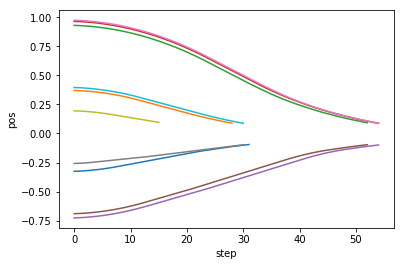

In [3]:
import rl.callbacks
class EpisodeLogger(rl.callbacks.Callback):
    def __init__(self):
        self.observations = {}
        self.rewards = {}
        self.actions = {}

    def on_episode_begin(self, episode, logs):
        self.observations[episode] = []
        self.rewards[episode] = []
        self.actions[episode] = []

    def on_step_end(self, step, logs):
        episode = logs['episode']
        self.observations[episode].append(logs['observation'])
        self.rewards[episode].append(logs['reward'])
        self.actions[episode].append(logs['action'])

cb_ep = EpisodeLogger()
dqn.test(env, nb_episodes=10, visualize=False, callbacks=[cb_ep])


%matplotlib inline
import matplotlib.pyplot as plt

for obs in cb_ep.observations.values():
    plt.plot([o[0] for o in obs])
plt.xlabel("step")
plt.ylabel("pos")